In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import rand, randn, choice, permutation
from scipy.linalg import hadamard

import torch
import torch.nn.functional as F

import tensorly as tl
from tensorly import decomposition
from tensorly.decomposition import parafac
from scipy import linalg

In [2]:
## Defining Measurement Matrices ##

## Returns gaussian mx(unweighted) of dimensionn m*N
def gaussian_mx(m,N): 
    A = np.random.normal(0.0, 1.0, [m, N])
    return A

def hadamard_mx(m,N):
    A = hadamard(N)
    l = permutation(np.range(N))
    return A[l[:m],:]

In [3]:
def vectorize_tl(X): ##Vectorisation for tensors
    x=X.numpy()
    x=x.reshape(-1)
    return x

def vectorize_np(X):  ##Vecorisation for numpy arrays
    x=X
    x=x.reshape(-1)
    return x

In [4]:
## Thresholding operators #########

def sparse_vect(x,s): ## s-sparse approximation
    
    x_1 = np.abs(x)
    index = np.flip(np.argsort(x_1))[:s]
    l = np.zeros(np.shape(x)[0])
    l[index] = x[index]

    return l

def sparse_vect_random(x,s):  ##Randomy selects indices to sparsify
    
    index = np.random.choice(np.shape(x)[0], s, replace=False)
    l = np.zeros(np.shape(x)[0])
    l[index] = x[index]
    
    return l

def random_low_rank_HOSVD(n,r,eps = 0.1):
    C=np.random.normal(0,1,size=r)+eps
    C=tl.tensor(C)
    C.shape
    X=C

    U=[]
    for i in range(len(n)):
        M=np.random.normal(0,1,size=(n[i],n[i]))+eps
        u,sigma,v=np.linalg.svd(M)
        U.append(u[:,0:r[i]])

    for i in range(len(n)):
        X=tl.tenalg.mode_dot(X,U[i],i)
    return X

def random_low_rank_CP(n,r,eps = 0.1):   #### CP Rank r
    #torch.manual_seed(0)
    #np.random.seed(0)
    
    L = []
    for i in range(0,len(n)):
        C=np.random.normal(0,1,size=(n[i],r))+eps
        L = L + [C]
    
    X = np.zeros(n)
    for i in range(r):
        U_r = np.array(L[0])[:,i]
        for j in range(1, len(n)):
            prod = np.array(L[j])[:,i]
            U_r = np.multiply.outer(U_r,prod)
        X = X + U_r
        
    C=tl.tensor(X) #Changing data frame to tensor
    C.shape
    return C

def HOSVD_rank_app(tensor,r): ## HOSVD rank-r approximation
    
    core, factors = tl.decomposition.tucker(tensor.numpy(), r) #Decomposition function is used 
    answer = torch.tensor(tl.tucker_to_tensor([core, factors]))
    
    return answer

def CP_rank_app(tensor,r):  ## CP rank-r approximation
    
    factors = parafac(tl.tensor(tensor), rank=r)
    answer = tl.cp_to_tensor(factors)
    
    return answer

In [5]:
def TIHT_CP(AA,yy,X,r,lamda = 1, itr = 100): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0 ##Random Initialisation

    for j in range(itr):
    
        WW = np.array(vectorize_np(vXX)) + lamda*np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_np(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = CP_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_np(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        
    return vXX, error

In [6]:
def TIHT_HOSVD(AA,yy,X,r,lamda = 1, itr = 100): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0

    for j in range(itr):
    
        WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_tl(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = HOSVD_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        
    return vXX, error

In [7]:
def KZIHT(A,b,x,s,gamma=1,itr=100): ## Selecting rows with replacement, gamma-step size for Kaczmarz
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y = np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error

In [8]:
def KZIHT_RR(A,b,x,s,gamma=1,itr=100): ## Selecting rows with replacement, gamma-step size for Kaczmarz
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y= np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
        
    return y,error

In [9]:
def KZIHT_HOSVD(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error

In [10]:
def KZPT_HOSVD_RR(A,b,X,n,r, period = 1,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
    t = permutation(np.arange(m))
            
    for k in range(itr): # Outer iteration for IHT updates
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
            if (j+1)%period == 0:
                WW = torch.reshape(torch.tensor(y), n)
                y = vectorize_tl(HOSVD_rank_app(WW,r))
                
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [11]:
def KZIHT_HOSVD_RR(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
            
    for k in range(itr): # Outer iteration for IHT updates
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error


In [12]:
def KZIHT_HOSVD_DET(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
            
    for k in range(itr): # Outer iteration for IHT updates
        
        t = np.arange(m)
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [13]:
def row_normalised_mx(A,b):
    B = np.zeros(np.shape(A))
    c = np.zeros(np.shape(b))
    for i in range(np.shape(A)[0]):
        B[i,:] = A[i,:]/np.linalg.norm(A[i,:])
        c[i] = b[i]/np.linalg.norm(A[i,:])
    return B,c

In [565]:
n = 1000
n_dim = [10,10,10]
r = [2,2,2]
itr = 250
m = 300

A_1 = np.random.normal(0.0,1.0,(n_dim[0],m))
A_2 = np.random.normal(0.0,1.0,(n_dim[1],m))
A_3 = np.random.normal(0.0,1.0,(n_dim[2],m))
A_4 = linalg.khatri_rao(A_1,linalg.khatri_rao(A_2,A_3))
A = A_4.T
#A = np.random.normal(0,1,(m,n))

X = random_low_rank_HOSVD(n_dim,r)
x = vectorize_np(X)

b = A@x
A_1,b_1 = row_normalised_mx(A,b)

In [691]:
y_IHT,error_IHT = TIHT_HOSVD(A,b,X,r,lamda=1/m,itr = 250)
y_IHT_2,error_IHT_2 = TIHT_HOSVD(A_1,b_1,X,r,lamda= n/m,itr = 250)
y_KZIHT, error_KZIHT = KZIHT_HOSVD_RR(A,b,X,n,r,gamma = n/m, itr = 250)

In [692]:
error_IHT

array([1.98156002e+000, 1.38823001e+001, 1.76147019e+002, 2.68263676e+003,
       4.29436829e+004, 6.93289074e+005, 1.14149332e+007, 1.88879899e+008,
       3.12954391e+009, 5.18776678e+010, 8.60107056e+011, 1.42610159e+013,
       2.36459974e+014, 3.92074046e+015, 6.50099332e+016, 1.07793298e+018,
       1.78732673e+019, 2.96357685e+020, 4.91392422e+021, 8.14780680e+022,
       1.35099267e+024, 2.24008895e+025, 3.71430476e+026, 6.15871074e+027,
       1.02117948e+029, 1.69322374e+030, 2.80754432e+031, 4.65520588e+032,
       7.71882446e+033, 1.27986286e+035, 2.12214819e+036, 3.51874649e+037,
       5.83445441e+038, 9.67414343e+039, 1.60407546e+041, 2.65972702e+042,
       4.41010913e+043, 7.31242809e+044, 1.21247803e+046, 2.01041701e+047,
       3.33348437e+048, 5.52727018e+049, 9.16479945e+050, 1.51962083e+052,
       2.51969230e+053, 4.17791674e+054, 6.92742850e+055, 1.14864103e+057,
       1.90456849e+058, 3.15797630e+059, 5.23625922e+060, 8.68227245e+061,
       1.43961274e+063, 2

In [693]:
error_IHT_2

array([1.08426574e+000, 2.62519662e+000, 7.66563220e+000, 2.51466640e+001,
       8.76526991e+001, 3.19210438e+002, 1.21739919e+003, 4.85891885e+003,
       2.01506607e+004, 8.58949712e+004, 3.73669338e+005, 1.65385221e+006,
       7.43278606e+006, 3.38533416e+007, 1.55949961e+008, 7.25366107e+008,
       3.40311373e+009, 1.62742201e+010, 8.14651122e+010, 4.09227672e+011,
       2.05623999e+012, 1.03323630e+013, 5.19197616e+013, 2.60898095e+014,
       1.31103189e+015, 6.58808075e+015, 3.31060377e+016, 1.66363322e+017,
       8.36006416e+017, 4.20109920e+018, 2.11111829e+019, 1.06086904e+020,
       5.33107628e+020, 2.67894869e+021, 1.34621215e+022, 6.76498076e+022,
       3.39950758e+023, 1.70830370e+024, 8.58456127e+024, 4.31387468e+025,
       2.16778678e+026, 1.08935534e+027, 5.47417869e+027, 2.75085686e+028,
       1.38235945e+029, 6.94656937e+029, 3.49075518e+030, 1.75417281e+031,
       8.81498872e+031, 4.42966383e+032, 2.22599277e+033, 1.11859566e+034,
       5.62111067e+034, 2

In [694]:
error_KZIHT

array([7.76695272e-01, 7.10983110e-01, 5.35482130e-01, 3.98078429e-01,
       2.77510360e-01, 2.08844565e-01, 1.53006214e-01, 1.13593384e-01,
       8.62543187e-02, 6.72340703e-02, 5.31415092e-02, 4.34224089e-02,
       3.25127142e-02, 2.53942774e-02, 2.01159370e-02, 1.56054657e-02,
       1.25981936e-02, 1.02185012e-02, 8.37983126e-03, 6.34646344e-03,
       5.21508571e-03, 4.07899641e-03, 3.16345052e-03, 2.61446056e-03,
       2.12863420e-03, 1.83203620e-03, 1.54603195e-03, 1.25031373e-03,
       1.02446221e-03, 8.33569729e-04, 6.50731037e-04, 5.47562570e-04,
       4.25326162e-04, 3.35036700e-04, 2.67804186e-04, 2.11347989e-04,
       1.74987645e-04, 1.47054605e-04, 1.17670322e-04, 9.92436367e-05,
       8.12664348e-05, 7.20643408e-05, 5.90228360e-05, 4.85350438e-05,
       3.96036623e-05, 3.21201591e-05, 2.69880643e-05, 2.21362090e-05,
       1.78128171e-05, 1.50379423e-05, 1.23518983e-05, 1.02837577e-05,
       8.45676258e-06, 6.87675920e-06, 5.60794741e-06, 4.57829683e-06,
      

In [590]:
np.save('x_2.npy', x)
np.save('a_1_2.npy',A_1)
np.save('a_2_2.npy',A_2)
np.save('a_3_2.npy',A_3)
np.save('a_4_2.npy',A_4)

In [633]:
n = 1000
n_dim = [10,10,10]
r = [2,2,2]
itr = 250
m = 300

A_4 = np.load('a_4_2.npy')
A = A_4.T

x = np.load('x_2.npy')
X = np.reshape(x,(10,10,10))

b = A@x
A_1,b_1 = row_normalised_mx(A,b)

In [634]:
#np.save('x.npy', x)
#np.save('a_1.npy',A_1)
#np.save('a_2.npy',A_2)
#np.save('a_3.npy',A_3)
#np.save('a_4.npy',A_4)

In [635]:
#######################################################
######## Analysing this Step-wise #####################
#######################################################

### First 5 iterations of IHT

vXX = torch.randn(n)*0
IHT_X = []
lamda = 1/m

for j in range(5):
    
    WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(vXX)))))  
    WW = torch.reshape(torch.tensor(WW), n_dim)
    vXX = HOSVD_rank_app(WW,r)
    IHT_X = IHT_X + [vXX]

    print(np.linalg.norm(vXX-X)/np.linalg.norm(X))


1.9815600153184483
13.882300104980517
176.14701934565366
2682.636755963114
42943.68293436173


In [636]:
### First 5 iterations of IHT (w/ normalised rows)

vXX = torch.randn(n)*0
IHTN_X = []
lamda = n/m

for j in range(5):
    
    WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(vXX)))))  
    WW = torch.reshape(torch.tensor(WW), n_dim)
    vXX = HOSVD_rank_app(WW,r)
    IHTN_X = IHTN_X + [vXX]

    print(np.linalg.norm(vXX-X)/np.linalg.norm(X))

2197.0212086718234
17222355.155240193
223499085446.92337
3529505419894787.5
5.899360312780203e+19


In [639]:
y = np.zeros(np.shape(x)[0]) 
KZIHT_X = []
lamda = n/m

t = permutation(np.arange(m))
            
for k in range(5): # Outer iteration for IHT updates
        
    for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[t[j],:]
        y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                        
    WW = torch.reshape(torch.tensor(y), n_dim)
    KZIHT_X = KZIHT_X + [y]
    y = vectorize_tl(HOSVD_rank_app(WW,r))
    
    print(np.linalg.norm(y-x)/np.linalg.norm(X))

0.8549441776585224
0.7638234464622998
0.6963519118708602
0.6422856003559547
0.5971072016455948


In [698]:
###########################################################
############### Angle of descent for the iterates ######### 
###########################################################

angles_IHT = []
angles_KZIHT = []

m = np.shape(A)[0]

n = 1000
n_dim = np.shape(X)
x = np.ravel(X)

gamma = n/m
lamda = 1/m
    
y = np.zeros(np.shape(x)[0])    
t = permutation(np.arange(m))
            
for k in range(10): # Outer iteration for IHT updates
    
    y_prev = y - x    ## previous iteration
        
    for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[t[j],:]
        y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
    
    u = y - x         ## the one that is thresholded                      
    WW = torch.reshape(torch.tensor(y), n_dim)
    y = vectorize_tl(HOSVD_rank_app(WW,r))
    v = y - x         ## post thresholding 
    
    angle = u.T@v/(np.linalg.norm(v)*np.linalg.norm(y_prev))
    angles_KZIHT = angles_KZIHT + [angle]
    

X_ravel = x
    
vXX = torch.randn(n)*0

for j in range(10):
    
    y_prev = (vectorize_tl(vXX)) - x
    WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(vXX)))))
    u = WW - x  
    WW = torch.reshape(torch.tensor(WW), n_dim)
    vXX = HOSVD_rank_app(WW,r)
    v = (vectorize_tl(vXX)) - x
    
    angle = u.T@v/(np.linalg.norm(v)*np.linalg.norm(y_prev))
    angles_IHT = angles_IHT + [angle]

In [699]:
angles_IHT

[1.8107310223954671,
 7.002713613857714,
 12.688562687716198,
 15.229608311107196,
 16.008008624938203,
 16.14414596507773,
 16.464896962318424,
 16.54673714994655,
 16.568962221666833,
 16.576750267475575]

In [697]:
angles_KZIHT

[0.7607912441795289,
 0.6212952377939084,
 0.8180712065163416,
 0.7481779172783868,
 0.7712034757572144,
 0.7759174104754318,
 0.7871026630316245,
 0.7816459092107453,
 0.7833636454726541,
 0.7814020747345611]

In [700]:
-np.array(angles_KZIHT)+np.array(angles_IHT)

array([ 0.98270923,  6.23243409, 11.97624645, 14.48458907, 15.30638564,
       15.39617291, 15.73430134, 15.80868398, 15.81609007, 15.81010751])

In [705]:
############### Stalled plotting angle ######################## 
ang_1 = []
for i in range(50):
    ang = A[i,:]@(np.ravel(x))/(np.linalg.norm(A[i,:])*np.linalg.norm(x))
    print(ang)
    ang_1 = ang_1 + [ang]

0.0425467699287495
0.006747806010819787
0.0033090495426669215
-0.03137138486061949
-0.0179056534125608
-0.0015234410690636445
0.013965182509999105
0.0018312992468812773
0.03665336452663969
0.015535930264404226
0.02177459316600294
-0.0034107076253644297
0.007089032736940827
-0.061531714106130765
0.03282995959775055
0.013700318023060055
0.04284542915705328
-0.001929192304102042
-0.03267369455543777
0.003762879303108178
-0.009445226159053815
0.005910958820533706
0.018721085187748555
-0.0041286023880791785
-0.0010973635440786446
0.001943908771476891
-0.15451065986814003
0.010221344183571453
-0.006481767573120767
-0.041890836647941715
0.014398235805080605
0.02985997148174107
-0.009359117362078579
0.001855897452140402
0.00621032827516685
0.011583668319228883
0.014098967106942042
0.0009168971688087281
-0.03819578467110455
-0.0008619457160693443
-0.009664983746651321
-0.021421274334050493
-0.02500764844491543
-0.0020774995704413487
0.02318618595067051
0.02938698530904563
-0.007505335701834683


In [706]:
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

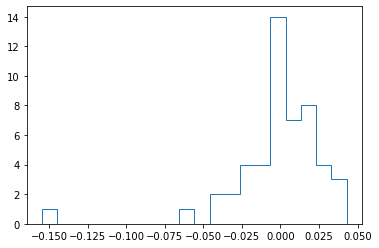

In [707]:
plt.stairs(hist, bins)

In [701]:
############### Stalled plotting angle ######################## 
ang_1 = []
for i in range(50):
    ang = A[i,:]@(np.ravel(np.array(IHT_X[0]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(IHT_X[0]))-x))
    print(ang)
    ang_1 = ang_1 + [ang]

0.07720282192823326
-0.0003046806862870354
-0.006126057503659072
0.010565950031709478
0.011005032152562879
-0.04413161294266952
-0.0469422821968611
-0.0017519918748620544
0.0007622952460053812
0.032090728931658305
0.0015129780040802393
0.009934825782788991
-0.007243757891837366
-0.013176304058373934
-0.06996430860767304
-0.02307508914097734
0.03741713977012864
-0.016713989360113334
0.014848408798961621
-0.003495530147956855
0.012111884518681348
-0.0011806436199827534
-0.0013354895368321849
-0.014350829708447864
0.007101142281168423
-0.006350659454013059
0.08452105591632635
-0.0019454227886701965
0.004258114137689666
-0.007530006317848765
-0.014732332758096826
0.015051943630771175
-0.0039348927712079835
0.008095913905068143
0.005847165164023427
-0.0020864872835911004
-0.05038678019292974
-0.008048054273017212
0.01728518929092603
0.020093349889301997
-0.0015398859383478505
0.016550807402306387
-0.0007290365229883104
0.009707154595769974
-0.02230187846021598
-0.021366541457378218
-0.01247

In [702]:
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

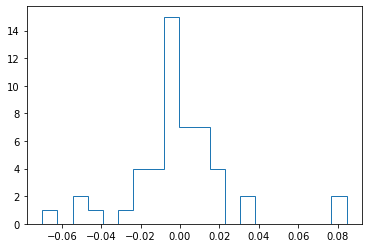

In [703]:
plt.stairs(hist, bins)

In [714]:
############### Stalled plotting angle ######################## 
ang_1 = []
for i in range(50):
    ang = A[i,:]@(np.ravel(np.array(KZIHT_X[0]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(KZIHT_X[0]))-x))
    print(ang)
    ang_1 = ang_1 + [ang]

-0.003970382319582073
-0.0013668639965722616
-0.0038792448774828967
0.01052950547273
-0.013087750642488273
-0.013925306399031319
-0.014760739914297173
-0.007936904894113101
-0.025560684105723395
-0.021117908338415738
-0.02003779695616178
0.0026681679988652006
-0.004881971859621039
0.022427491755728925
-0.013425232493293505
-0.011959337172958039
-0.015388470200884881
0.013376232871311915
0.0064954232253041115
0.001984047494540961
-0.0006234959178129224
0.002141253179499104
-0.00787567280252191
0.003196937897104513
0.004957901510243893
-0.0053685536437041124
0.05802204736131589
0.005375966052104895
0.009455538278143575
0.017009120396637902
0.008287629239431257
0.0008926455727802471
0.010495848631393193
0.007249201462174001
0.007249885617332216
-0.013799460092648513
-0.003054365714062406
0.009364079635855267
0.011806896098850168
0.007405574107320546
0.0016602598988219315
0.005975617478726645
-0.00030280038652422765
-0.0036781208839363373
-0.0071543910084686845
0.0011206201095281267
-0.003

In [715]:
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

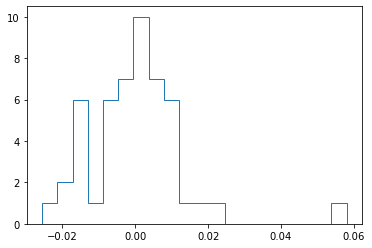

In [716]:
plt.stairs(hist, bins)

In [726]:
## Before thresholding iteration 1

t = torch.randn(n)*0

gr_ih = np.array(vectorize_tl(t)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(t)))))
y = np.zeros((1000))
p = permutation(np.arange(m))
                                                            
for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[p[j],:]
        y = y + gamma*(b[p[j]] - a@y)*a/(np.linalg.norm(a)**2)

gr_kz = y 

In [727]:
np.linalg.norm(A@gr_ih-b)

378.66746637270916

In [728]:
np.linalg.norm(A@gr_kz-b)

111.20851621491062

In [729]:
WW = torch.reshape(torch.tensor(gr_ih), n_dim)
tr_ih = vectorize_tl(HOSVD_rank_app(WW,r))

WW = torch.reshape(torch.tensor(gr_kz), n_dim)
tr_kz = HOSVD_rank_app(WW,r)

In [737]:
print(np.linalg.norm(A@np.ravel(np.array(tr_ih))-b))
print(np.linalg.norm(A@np.ravel(np.array(tr_kz))-b))

189.3161997888633
31.542031486830595


In [739]:
## Before thresholding iteration 2

gr_ih = np.array(vectorize_tl(IHT_X[0])) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(IHT_X[0])))))
y = KZIHT_X[0]
                                                            
for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[p[j],:]
        y = y + gamma*(b[p[j]] - a@y)*a/(np.linalg.norm(a)**2)

gr_kz = y 

In [740]:
np.linalg.norm(A@gr_ih-b)

2442.3155630737415

In [741]:
np.linalg.norm(A@gr_kz-b)

65.07170967959912

In [742]:
WW = torch.reshape(torch.tensor(gr_ih), n_dim)
tr_ih = vectorize_tl(HOSVD_rank_app(WW,r))

WW = torch.reshape(torch.tensor(gr_kz), n_dim)
tr_kz = HOSVD_rank_app(WW,r)

In [743]:
print(np.linalg.norm(A@np.ravel(np.array(tr_ih))-b))
print(np.linalg.norm(A@np.ravel(np.array(tr_kz))-b))

1865.4683428345504
23.754479340894612


In [744]:
## Before thresholding iteration 3

gr_ih = np.array(vectorize_tl(IHT_X[1])) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(IHT_X[1])))))
y = KZIHT_X[0]
                                                            
for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[p[j],:]
        y = y + gamma*(b[p[j]] - a@y)*a/(np.linalg.norm(a)**2)

gr_kz = y 

In [745]:
np.linalg.norm(A@gr_ih-b)

28583.42462006642

In [746]:
np.linalg.norm(A@gr_kz-b)

65.07170967959912

In [747]:
WW = torch.reshape(torch.tensor(gr_ih), n_dim)
tr_ih = vectorize_tl(HOSVD_rank_app(WW,r))

WW = torch.reshape(torch.tensor(gr_kz), n_dim)
tr_kz = HOSVD_rank_app(WW,r)

In [748]:
print(np.linalg.norm(A@np.ravel(np.array(tr_ih))-b))
print(np.linalg.norm(A@np.ravel(np.array(tr_kz))-b))

26429.536512847364
23.754479340894612


In [754]:
## Before thresholding iteration 3

gr_ih = np.array(vectorize_tl(IHT_X[2])) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(IHT_X[2])))))
y = KZIHT_X[2]
                                                            
for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[p[j],:]
        y = y + gamma*(b[p[j]] - a@y)*a/(np.linalg.norm(a)**2)

gr_kz = y 

In [755]:
np.linalg.norm(A@gr_ih-b)

431765.54997602466

In [756]:
np.linalg.norm(A@gr_kz-b)

46.75924478793503

In [757]:
WW = torch.reshape(torch.tensor(gr_ih), n_dim)
tr_ih = vectorize_tl(HOSVD_rank_app(WW,r))

WW = torch.reshape(torch.tensor(gr_kz), n_dim)
tr_kz = HOSVD_rank_app(WW,r)

In [758]:
print(np.linalg.norm(A@np.ravel(np.array(tr_ih))-b))
print(np.linalg.norm(A@np.ravel(np.array(tr_kz))-b))

416105.82046378404
17.936240652434694


In [670]:
max1 = 0
min1 = 0
ang_1 = []
ang_max = 0
ang_min = 0
for i in range(50):
    ang = A[i,:]@(np.ravel(np.array(y_IHT_new))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(y_IHT_new))-x))
    if i == 0:
        ang_max = ang
        ang_min = ang
    else:
        if ang > ang_max:
            ang_max = ang
            max1 = i
        if ang< ang_min:
            min1 = i
    print(ang)
    ang_1 = ang_1 + [ang]

-0.016544322287792852
-0.018764665638797213
-0.008340169794793163
-0.007728959147584248
0.028155086455241674
-0.023002744241638843
-0.01915301150968904
-0.007827405529836757
-0.028118606862880403
-0.008151300146660604
0.023953244459121316
0.020275816156071855
0.011355681597675827
0.014108953181935127
-0.01483845468173448
-0.001373574071064973
0.009649960984579613
-0.0007108258542152518
0.015665518680568518
-0.005497736699909162
0.011054136003537291
0.0030669203737879163
-0.005921111066834805
4.906124036206215e-06
0.0002487320027907882
-0.0052669736551852805
0.000759885830098382
-0.002285883492075064
-0.00025598574474921236
-0.015040668327687363
-0.007274941353150803
-0.011032503166841928
0.004507324223249347
0.0010139065082245457
-0.012988353001010412
-0.025802524332504878
-0.02851531403778989
0.010422233731235192
-0.005526259950676128
0.006442839960075683
0.007308846418026562
0.013061274935658293
-0.011339616838702014
-0.005439183387624965
-0.027910352830741197
-0.01479030896722967
0.

In [672]:
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

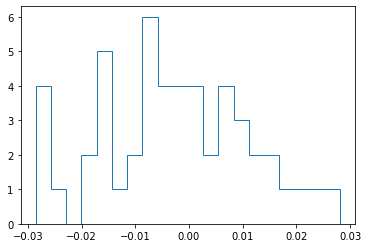

In [673]:
plt.stairs(hist, bins)

In [687]:
b = np.delete(A, (max1,min1), )

4

In [675]:
t = permutation(np.arange(m))

y = vectorize_tl(y_IHT)
        
for j in range(m): #Inner iteration for Kaczmarz updates
            
    a = A[t[j],:]
    y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                        
WW = torch.reshape(torch.tensor(y), n_dim)
y = vectorize_tl(HOSVD_rank_app(WW,r))

In [676]:
ang_2 = []
for i in range(50):
    ang = A[i,:]@(np.ravel(np.array(y))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(y))-x))
    print(ang)
    ang_2 = ang_2 + [ang]

-0.01696430743154277
-0.017562741046742728
-4.4888834558077106e-05
8.325127291528803e-06
0.025630698933814717
-0.014848723716232602
-0.013983093875632659
-0.010738942819249558
-0.023253890255659923
-0.010105996252780957
0.01217500755736613
0.01409246965357508
0.007959208244212895
0.017347729392362846
-0.010608384022931747
0.013714916211489117
0.004517376443899827
-0.008767439339297179
0.027734946794037228
-0.013389309416702319
0.010034541665079963
0.00033519997055412795
-0.0018794661955254751
-0.01031216159590351
0.0012113187285924612
-0.005395057215719683
-0.0018633599248949202
0.016763662334361353
0.009525840075832643
-0.012040715665317498
0.0032726954581522804
-0.014292218181847364
0.004160199964176449
-0.00128604534292706
-0.006046892982910732
-0.01183562006996712
-0.033733770268693605
0.0036544548118611743
-0.017077856354616963
0.011782065669136315
0.010010054253046472
0.010581830277294889
-0.01721557173669665
-0.004284700577218713
-0.025496793977968602
0.020461671037207068
0.0109

In [677]:
hist, bins = np.histogram(np.array(ang_2), bins=20, range=None, density=None, weights=None)

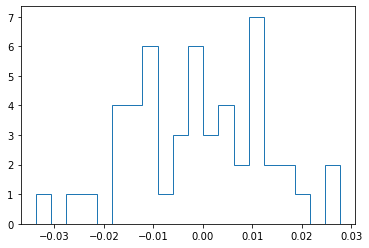

In [678]:
plt.stairs(hist, bins)

In [684]:
##########################################################
#### Understanding first 5 iterations ####################

## IHT

for i in range(5):
    
    y = np.ravel(np.array(IHT_X[i]))
    print(np.linalg.norm(A@(y-x))/np.linalg.norm(y-x))

43.953029184065414
61.82081388685306
69.02755838943256
71.35923467108468
71.58475858643303


In [685]:
## IHTN

for i in range(5):
    
    y = np.ravel(np.array(IHTN_X[i]))
    print(np.linalg.norm(A@(y-x))/np.linalg.norm(y-x))

45.72764437359409
59.869550821743566
68.0358562964393
70.49475288751444
72.19965839777049


In [686]:
## KZIHT

for i in range(5):
    
    y = np.ravel(np.array(KZIHT_X[i]))
    print(np.linalg.norm(A@(y-x))/np.linalg.norm(y-x))

8.388087079266658
7.2984521201077035
6.655338240233401
6.222192532180019
5.904704109529353


In [ ]:
########################################################################
###### Looking at just the gradient steps (Before thresholding)#########

